#### Muhammad Raditya Putra_2110511004
#### Malique Abdul Aziz_2110511044
#### David Siddi_2110511062
#### Wahyu Dhia Satwika_2110511066

Dataset yang kita gunakan didapatkan dari situs kaggle sebagai berikut https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set. Untuk dataset yang akan dibaca, terdapat beberapa modifikasi yang sebelumnya kami download dari kaggle dan kami lampirkan pada link sebagai berikut https://drive.google.com/file/d/1VlH1Jz06PPPs6RxJNwM-oXJRlbZ74yvj/view?usp=sharing. 

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
tf.__version__


'2.10.1'

In [5]:
# Define the root directory of your dataset
root_dir = 'dataset'

# Create directories for the training, validation, and test sets
train_dir = os.path.join(root_dir, 'train_set')
validation_dir = os.path.join(root_dir, 'validation_set')
test_dir = os.path.join(root_dir, 'test_set')

# Create the validation directory if it doesn't exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

# Split the data into training, validation, and test sets
validation_split = 0.2  # You can adjust the validation split ratio

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    
    if os.path.isdir(class_dir):  # Check if it's a directory
        images = [image for image in os.listdir(class_dir) if not image.startswith('.')]  # Filter out hidden files
        train_images, val_images = train_test_split(images, test_size=validation_split, random_state=42)

        # Move images to the appropriate directories
        for image in val_images:
            source = os.path.join(class_dir, image)
            destination = os.path.join(validation_dir, class_name, image)
            os.makedirs(os.path.dirname(destination), exist_ok=True)
            shutil.move(source, destination)

In [6]:
# Create ImageDataGenerators for training, validation, and testing
batch_size = 8
target_size = (256, 256)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=7,
    horizontal_flip=True,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=1,  # Set batch_size to 1 for testing
    class_mode='categorical',
    shuffle=False
)


Found 881 images belonging to 2 classes.
Found 15208 images belonging to 2 classes.
Found 1991 images belonging to 2 classes.


In [4]:
train_dataset.class_indices

{'non-vehicles': 0, 'vehicles': 1}

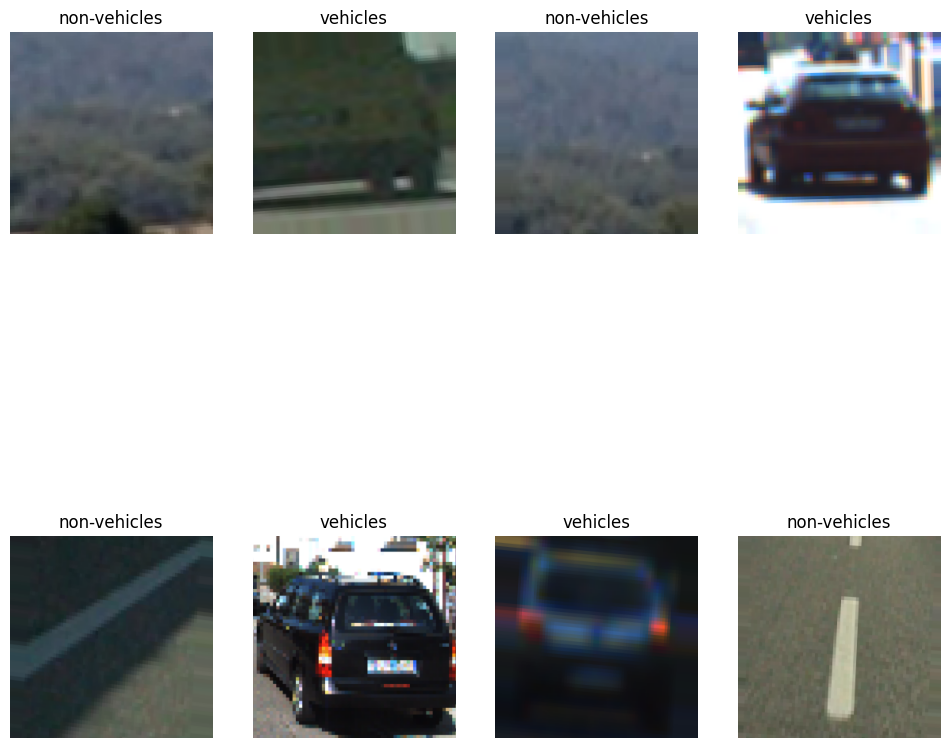

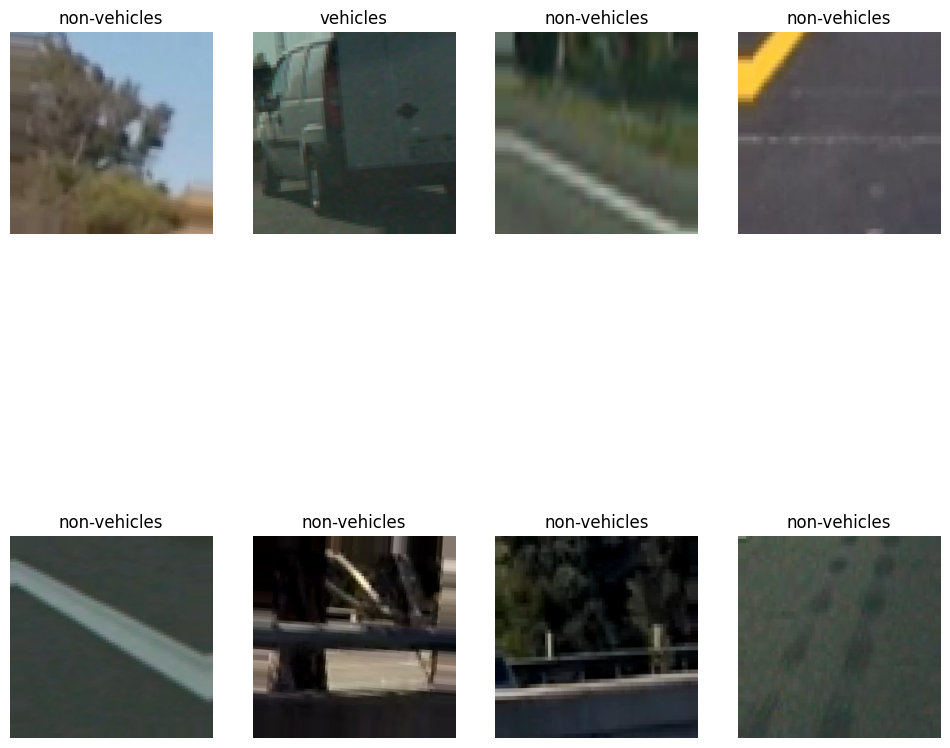

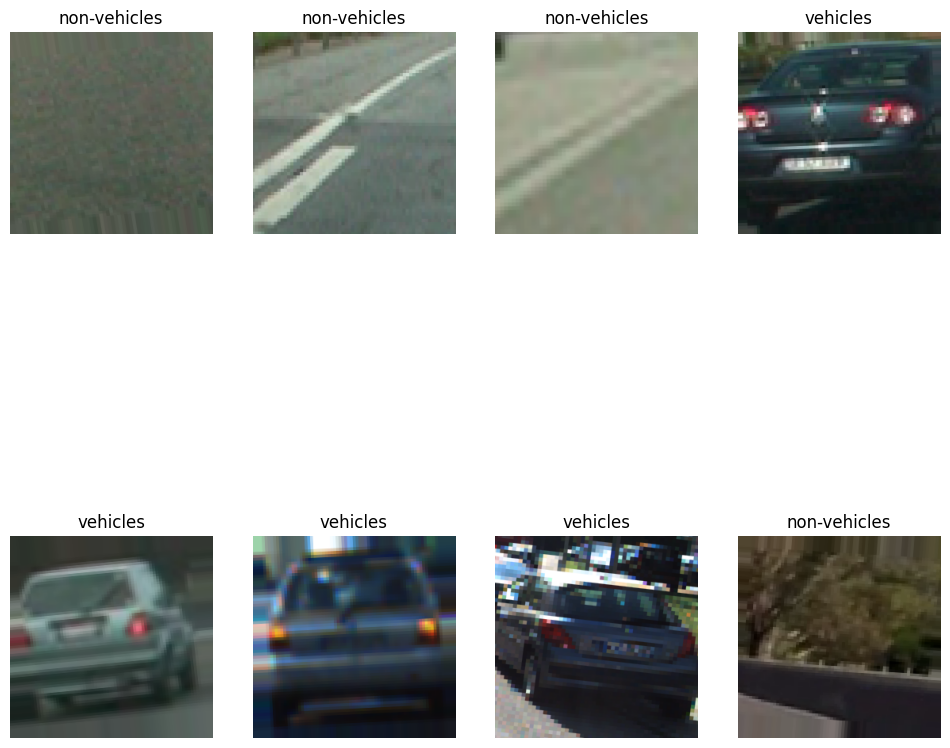

In [5]:
# Set the number of batches to visualize
num_batches_to_visualize = 5

# Iterate over batches and show images
for batch_num in range(3):
    # Get a batch from the training dataset
    images, labels = train_dataset.next()

    # Display the images in a grid
    plt.figure(figsize=(12, 12))
    for i in range(batch_size):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        
        # Assuming you have a list of class names
        classes = train_dataset.class_indices
        class_index = np.argmax(labels[i])
        class_name = [k for k, v in classes.items() if v == class_index][0]
        
        plt.title(class_name)
        plt.axis('off')

    plt.show()

In [8]:
#Callbacks untuk Model Training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [15]:
def plot_training(history):
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,6))
    plt.plot(history.history['accuracy'],c='blue')
    plt.plot(history.history['loss'],c='red')
    plt.plot(history.history['val_accuracy'],c='blue', linestyle='dashed')
    plt.plot(history.history['val_loss'],c='red', linestyle='dashed')
    plt.title("Accuracy and Loss Per Epochs", fontsize=20)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy and Loss", fontsize=14)
    plt.legend(["Accuracy","Loss","Val_Accuracy","Val_Loss"], fontsize=14,loc=[1.02,0.5])
    plt.show()

In [14]:
def predict_vehicle_binary(image, model, threshold=0.5):
    img = keras.preprocessing.image.load_img(image)
    img_arr = keras.utils.img_to_array(img)
    img_arr = img_arr / 255.
    img_arr = tf.image.resize(img_arr, [256, 256])
    preds_arr = model.predict(tf.expand_dims(img_arr, axis=0))
    
    # Use sigmoid activation, so preds_arr is in [0, 1]
    pred_prob = preds_arr[0, 0]
    
    # Get the predicted class index (0 or 1)
    predicted_class = 1 if pred_prob > threshold else 0
    
    # Map class index to class label
    class_labels = ["Kendaraan", "Bukan Kendaraan"]
    prediction = class_labels[predicted_class]

    plt.figure(figsize=(2, 2), dpi=200)
    plt.imshow(img)
    plt.title(prediction, fontsize=12)
    plt.axis('off')
    return predicted_class, pred_prob


In [11]:
print("Classes:", classes)

Classes: {'non-vehicles': 0, 'vehicles': 1}


In [13]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape=(256, 256, 3)))

In [14]:
ResNet_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [15]:
len(ResNet_model.layers)

564

In [16]:
for layer in ResNet_model.layers:
    layer.trainable=False

In [17]:
head_model = ResNet_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(1, activation='sigmoid')(head_model)

In [18]:
network_ResNet = Model(inputs=ResNet_model.input, outputs=head_model)

In [19]:
network_ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
network_ResNet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = network_ResNet.fit(train_dataset, 
                        epochs=50,
                        validation_data=validation_generator, 
                        callbacks=[early_stopping,
                                    reduce_lr])

plot_training(history)

In [ ]:
network_ResNet.save("model2.keras")

In [ ]:
with open('history2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [3]:
with open('history2.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

In [2]:
loaded_model = load_model("model2.keras")

In [7]:
predictions = loaded_model.predict(test_dataset)
predictions 

1991/1991 [==============================] - 56s 25ms/step


array([[1.0000000e+00, 2.0631832e-09],
       [1.0000000e+00, 2.8699001e-08],
       [1.0000000e+00, 2.4272305e-08],
       ...,
       [1.4572100e-08, 1.0000000e+00],
       [6.9876505e-09, 1.0000000e+00],
       [2.9573299e-09, 1.0000000e+00]], dtype=float32)

In [8]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [9]:
test_dataset.classes

array([0, 0, 0, ..., 1, 1, 1])

<Axes: >

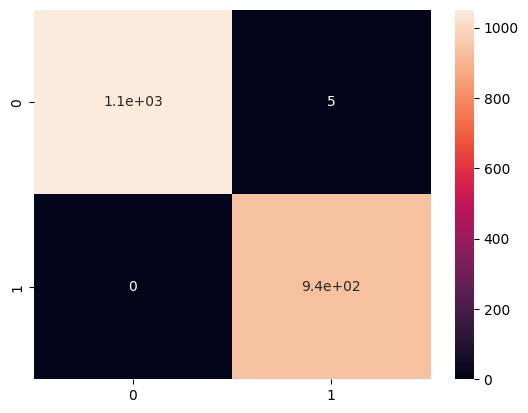

In [10]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [11]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1056
           1       0.99      1.00      1.00       935

    accuracy                           1.00      1991
   macro avg       1.00      1.00      1.00      1991
weighted avg       1.00      1.00      1.00      1991



1/1 [==============================] - 2s 2s/step
Predicted Class: 0
Probability: 5.1644583e-06


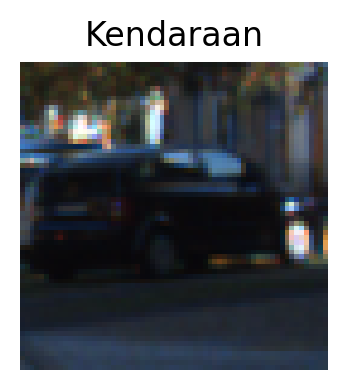

In [15]:
image_path = 'dataset/test_set/vehicles/3516.png'
predicted_class, pred_prob = predict_vehicle_binary(image_path, loaded_model)

print("Predicted Class:", predicted_class)
print("Probability:", pred_prob)


1/1 [==============================] - 0s 31ms/step
Predicted Class: 0
Probability: 3.5171107e-07


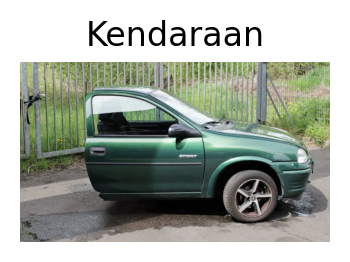

In [16]:
image_path = 'mobil_setengah.jpg'
predicted_class, pred_prob = predict_vehicle_binary(image_path, loaded_model)

print("Predicted Class:", predicted_class)
print("Probability:", pred_prob)


1/1 [==============================] - 0s 31ms/step
Predicted Class: 1
Probability: 0.9701816


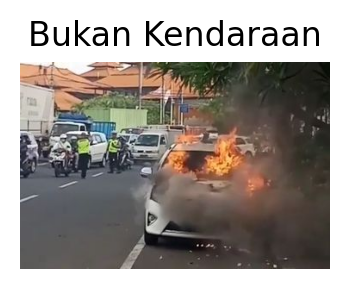

In [17]:
image_path = 'mobil_asap.jpg'
predicted_class, pred_prob = predict_vehicle_binary(image_path, loaded_model)

print("Predicted Class:", predicted_class)
print("Probability:", pred_prob)


1/1 [==============================] - 0s 30ms/step
Predicted Class: 0
Probability: 1.0263632e-06


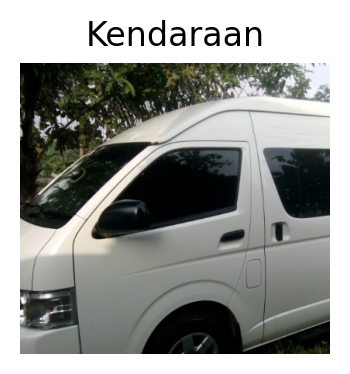

In [19]:
image_path = 'mobil_cropped.png'
predicted_class, pred_prob = predict_vehicle_binary(image_path, loaded_model)

print("Predicted Class:", predicted_class)
print("Probability:", pred_prob)

1/1 [==============================] - 0s 33ms/step
Predicted Class: 0
Probability: 2.8980228e-05


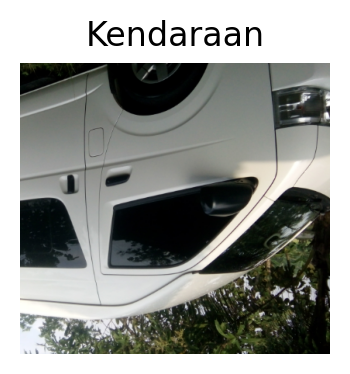

In [20]:
image_path = 'mobil_kebalik.png'
predicted_class, pred_prob = predict_vehicle_binary(image_path, loaded_model)

print("Predicted Class:", predicted_class)
print("Probability:", pred_prob)

1/1 [==============================] - 0s 28ms/step
Predicted Class: 0
Probability: 0.0028123306


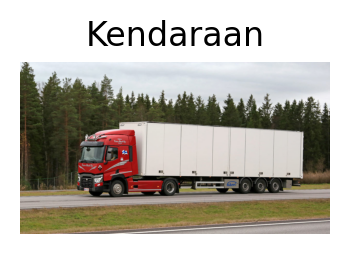

In [21]:
image_path = 'truk.jpg'
predicted_class, pred_prob = predict_vehicle_binary(image_path, loaded_model)

print("Predicted Class:", predicted_class)
print("Probability:", pred_prob)